[('/content/drive/MyDrive/dataset/saclay_e/imgs_1_rect/B03.tif', '/content/drive/MyDrive/dataset/saclay_e/imgs_2_rect/B01.tif', '/content/drive/MyDrive/dataset/saclay_e/cm_mask.tif'), ('/content/drive/MyDrive/dataset/saclay_e/imgs_1_rect/B04.tif', '/content/drive/MyDrive/dataset/saclay_e/imgs_2_rect/B04.tif', '/content/drive/MyDrive/dataset/saclay_e/cm_mask.tif'), ('/content/drive/MyDrive/dataset/saclay_e/imgs_1_rect/B01.tif', '/content/drive/MyDrive/dataset/saclay_e/imgs_2_rect/B02.tif', '/content/drive/MyDrive/dataset/saclay_e/cm_mask.tif'), ('/content/drive/MyDrive/dataset/saclay_e/imgs_1_rect/B02.tif', '/content/drive/MyDrive/dataset/saclay_e/imgs_2_rect/B03.tif', '/content/drive/MyDrive/dataset/saclay_e/cm_mask.tif'), ('/content/drive/MyDrive/dataset/saclay_e/imgs_1_rect/B08.tif', '/content/drive/MyDrive/dataset/saclay_e/imgs_2_rect/B05.tif', '/content/drive/MyDrive/dataset/saclay_e/cm_mask.tif'), ('/content/drive/MyDrive/dataset/saclay_e/imgs_1_rect/B09.tif', '/content/drive/MyDr

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.40081940591335297
Precision: 0.0
Accuracy: 1.0


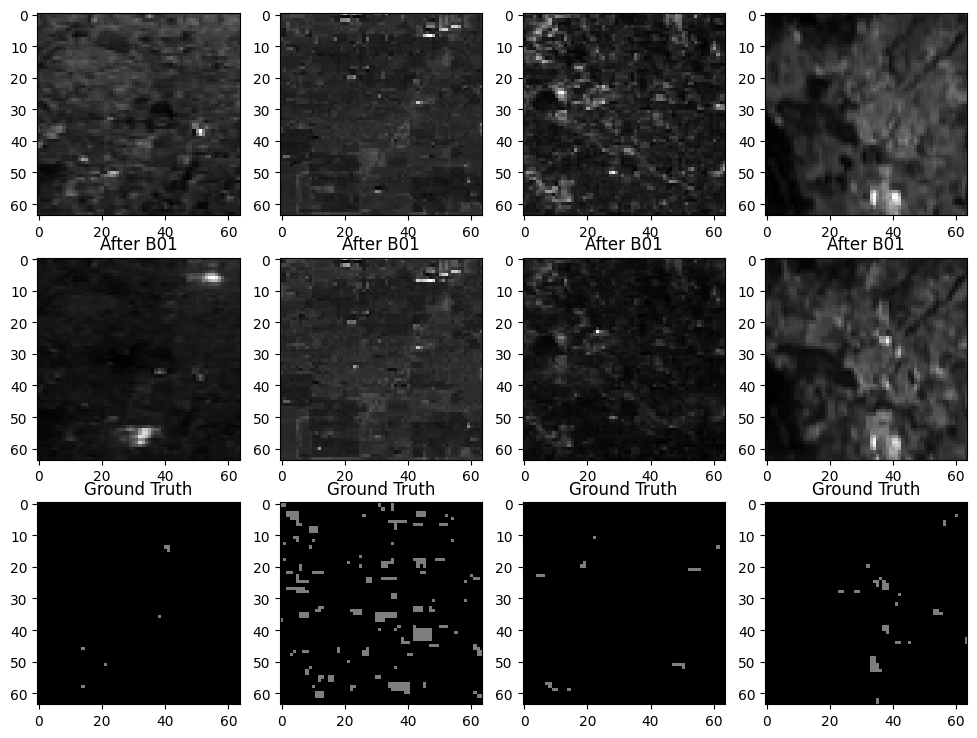

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import precision_score, accuracy_score

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(24, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.decoder2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x2 = nn.functional.interpolate(x2, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.decoder1(x2)
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.decoder2(x)
        return x

class ChangeDetectionDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.image_pairs = []

        for city in os.listdir(dataset_path):
            city_path = os.path.join(dataset_path, city)
            img_before_dir = os.path.join(city_path, "imgs_1_rect")
            img_after_dir = os.path.join(city_path, "imgs_2_rect")
            label_path = os.path.join(city_path, "cm_mask.tif")

            if os.path.exists(img_before_dir) and os.path.exists(img_after_dir) and os.path.exists(label_path):
                img_before_files = [os.path.join(img_before_dir, f) for f in os.listdir(img_before_dir) if f.endswith('.tif')]
                img_after_files = [os.path.join(img_after_dir, f) for f in os.listdir(img_after_dir) if f.endswith('.tif')]

                for img_before, img_after in zip(img_before_files, img_after_files):
                    self.image_pairs.append((img_before, img_after, label_path))

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        img_before_path, img_after_path, label_path = self.image_pairs[idx]

        img_before = []
        img_after = []

        for i in range(1, 13):
            file = os.path.join(os.path.dirname(img_before_path), f"B{str(i).zfill(2)}.tif")
            if os.path.exists(file):
                img = Image.open(file)
                img = img.resize((64, 64))
                img_before.append(img)

        if not img_before:
            print(f"Warning: No 'before' images found for {img_before_path}")
            return None

        for i in range(1, 13):
            file = os.path.join(os.path.dirname(img_after_path), f"B{str(i).zfill(2)}.tif")
            if os.path.exists(file):
                img = Image.open(file)
                img = img.resize((64, 64))
                img_after.append(img)

        label = Image.open(label_path).convert('L')
        label = label.resize((64, 64))

        img_before = np.stack([np.array(img) for img in img_before], axis=-1)
        img_after = np.stack([np.array(img) for img in img_after], axis=-1)
        img_combined = np.concatenate((img_before, img_after), axis=-1)

        img_combined = torch.tensor(img_combined).permute(2, 0, 1).float() / 255.0
        label = torch.tensor(np.array(label)).unsqueeze(0).float() / 255.0

        return img_combined, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*24, std=[0.5]*24)
])

dataset_path = "/content/drive/MyDrive/dataset"
dataset = ChangeDetectionDataset(dataset_path, transform=transform)
print(dataset.image_pairs)
print(len(dataset))

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

model.eval()
test_loss = 0.0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds = (outputs > 0.5).int().float()
        labels = (labels > 0.5).int().float()
        all_labels.extend(labels.cpu().numpy().flatten())
        all_preds.extend(preds.cpu().numpy().flatten())

    avg_test_loss = test_loss / len(test_loader)
    precision = precision_score(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)

    print(f"Test Loss: {avg_test_loss}")
    print(f"Precision: {precision}")
    print(f"Accuracy: {accuracy}")

def visualize_results(model, test_loader):
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            outputs = outputs.cpu().numpy()
            images = images.cpu().numpy()
            labels = labels.cpu().numpy()
            break

    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    for i in range(4):
        axes[0, i].imshow(images[i, :1].transpose(1, 2, 0).squeeze(), cmap='gray')
        axes[1, i].imshow(images[i, 12:13].transpose(1, 2, 0).squeeze(), cmap='gray')
        axes[1, i].set_title('After B01')
        axes[2, i].imshow(outputs[i, 0], cmap='gray')
        axes[2, i].set_title('Predicted Change')
        axes[2, i].imshow(labels[i, 0], cmap='gray', alpha=0.5)
        axes[2, i].set_title('Ground Truth')
    plt.show()

visualize_results(model, test_loader)